# Bicycle Commuting Data

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

The data used for the analysis was taken from three datasets of Mexico City's government [website](https://datos.cdmx.gob.mx/):

| Dataset                         | Location    | Date of download |
| ------------------------------- | ------------------------------------------------------------ | ---------------- |
| Bicycle counter                 | https://datos.cdmx.gob.mx/dataset/contador-ciclistas         | 11-Dec-2020      |
| Road accidents                  | https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5       | 11-Dec-2020      |
| Estudio de Conteo ciclista 2018 | https://datos.cdmx.gob.mx/dataset/estudio-de-conteo-ciclista-2018 | 11-Dec-2020      |

I have already downloaded them in the /Data directory, so let's import them.

In [4]:
contador = pd.read_csv('Data/contador-ciclistas.csv')
incidentes = pd.read_csv('Data/incidentes-viales-c5.csv')
estudio = pd.read_csv('Data/estudio-de-conteo-ciclista-2018.csv')

## 1. Bicycle counter

### Data exploration

In [5]:
contador.head()

,Día de la semana,Día,Mes,Año,Contador Ruta Reforma222,Contador Ruta Revolución,Contador Ruta Patriotismo
0,jueves,5,diciembre,2013,2516.0,NaN,NaN
1,lunes,9,diciembre,2013,2132.0,NaN,NaN
2,viernes,22,junio,2018,2913.0,980.0,1163.0
3,martes,10,julio,2018,2531.0,877.0,1013.0
4,sábado,7,julio,2018,1534.0,616.0,584.0


In [6]:
contador.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2374 entries, 0 to 2373
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Día de la semana           2374 non-null   object 
 1   Día                        2374 non-null   int64  
 2   Mes                        2374 non-null   object 
 3   Año                        2374 non-null   int64  
 4   Contador Ruta Reforma222   2150 non-null   float64
 5   Contador Ruta Revolución   1382 non-null   float64
 6   Contador Ruta Patriotismo  1386 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 130.0+ KB


In [7]:
contador.isnull().sum()

Día de la semana               0
Día                            0
Mes                            0
Año                            0
Contador Ruta Reforma222     224
Contador Ruta Revolución     992
Contador Ruta Patriotismo    988
dtype: int64

It seems that the counters didn't start recolecting data at the same time. We should see when did each start by  visualizing where exactly are the null values. However, the dataset is not ordered by date, so let's transform the dates to a datetime format.

### Data cleaning

In [8]:
# Change column names
contador.columns

Index(['Día de la semana', 'Día', 'Mes', 'Año', 'Contador Ruta Reforma222',
       'Contador Ruta Revolución', 'Contador Ruta Patriotismo'],
      dtype='object')

In [9]:
contador.columns = ['Día de la semana', 'Día', 'Mes', 'Año', 'Reforma', 'Revolución', 'Patriotismo']

In [10]:
# Transform months to categories to order them.
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
contador['Mes'] = pd.Categorical(contador['Mes'], meses)

# Order values in descending order.
contador = contador.sort_values(['Año', 'Mes', 'Día'])

# Change months back to object type
contador['Mes'] = contador['Mes'].astype('object')

In [11]:
# Label-encode months
dict_meses = {}
number = 0
for mes in meses: 
    number += 1
    dict_meses[mes] = number
    
contador['Mes'] = contador['Mes'].map(dict_meses)

In [12]:
# Create new column with complete date
contador.insert(4, 'Fecha', pd.to_datetime(contador.Año*10000+contador.Mes*100+contador.Día, format='%Y%m%d'))

In [13]:
# Reset indexes
contador = contador.reset_index(drop=True)

In [14]:
contador.head(4)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
0,sábado,16,11,2013,2013-11-16,613.0,NaN,NaN
1,domingo,17,11,2013,2013-11-17,1084.0,NaN,NaN
2,lunes,18,11,2013,2013-11-18,1073.0,NaN,NaN
3,martes,19,11,2013,2013-11-19,1344.0,NaN,NaN


In [15]:
# Change months back to string format
dict_meses_inverso = {}
for mes, numero in dict_meses.items():
    dict_meses_inverso[numero] = mes
    
contador['Mes'] = contador['Mes'].map(dict_meses_inverso)

In [16]:
# Replace special characters
contador['Día de la semana'] = contador['Día de la semana'].str.replace('á', 'a').str.replace('é', 'e')

Now that we have a clean and ordered dataset, we can visualize the distribution of null values.

In [17]:
# Create dictionary with column types.
def recognize_column_type(dtf, col, max_cat=20):
    """Returns the type of a column"""
    
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

dic_cols = {col:recognize_column_type(contador, col, max_cat=20) for col in contador.columns}

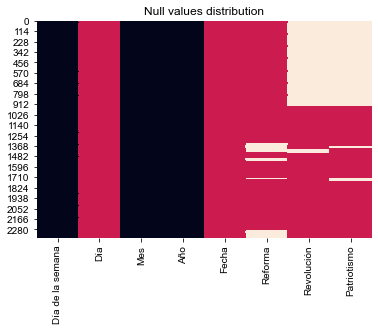

 Categorical   Numeric   NaN 


In [18]:
# Visualize data
heatmap = contador.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
        
sns.heatmap(heatmap, cbar=False).set_title('Null values distribution')
sns.set(rc={'figure.figsize':(10,5)});
plt.show()
print("\033[1;37;40m Categorical ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [19]:
contador.head(1)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
0,sabado,16,noviembre,2013,2013-11-16,613.0,NaN,NaN


In [18]:
contador[contador['Revolución'].notnull()].head(4)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
941,martes,14,junio,2016,2016-06-14,2884.0,333.0,256.0
942,miercoles,15,junio,2016,2016-06-15,2909.0,864.0,993.0
943,jueves,16,junio,2016,2016-06-16,283.0,855.0,901.0
944,viernes,17,junio,2016,2016-06-17,2695.0,889.0,856.0


The first counter that the government installed seems to be Reforma, in **16 Nov 2013**. Afterward, the counters for avenue Revolución and Patriotismo were installed in **14 June 2016**.

In [20]:
contador.tail()

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
2369,sabado,26,septiembre,2020,2020-09-26,NaN,653.0,710.0
2370,domingo,27,septiembre,2020,2020-09-27,NaN,586.0,890.0
2371,lunes,28,septiembre,2020,2020-09-28,NaN,660.0,620.0
2372,martes,29,septiembre,2020,2020-09-29,NaN,633.0,571.0
2373,miercoles,30,septiembre,2020,2020-09-30,NaN,750.0,670.0


Moreover, the last available values are for **September of 2020**. We should keep this in mind when we visualize the information.

Besides the missing values, we should also check that we have data for all months within our range (since maybe the counters do not register all months equally):

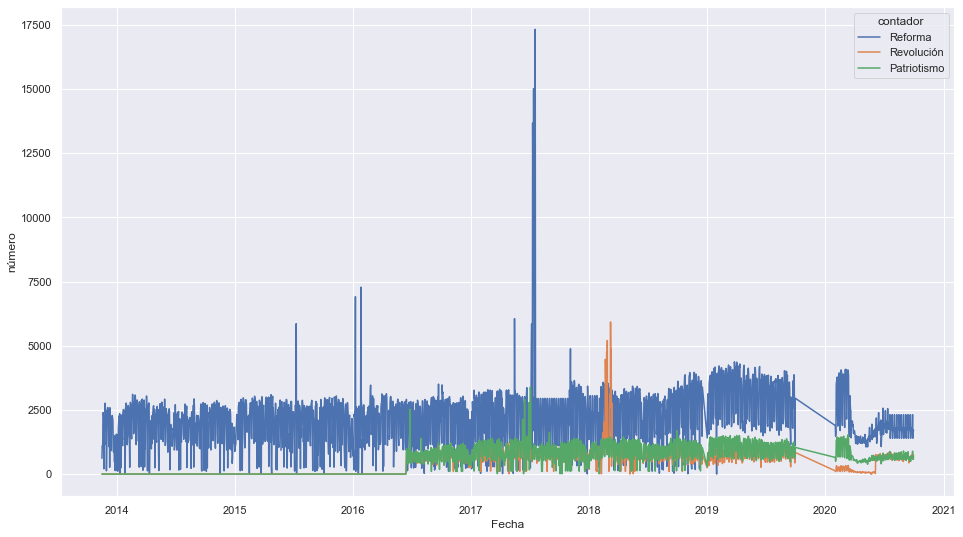

In [35]:
sns.set_theme()
data_lineplot = pd.melt(contador[['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot)

#Change figure size
sns.set(rc={'figure.figsize':(17,10)});

It is difficult to tell if we have data available for all months. However, we can identify other insights:
- We confirm the gaps of missing values that we saw previously in the Reforma counter. 
- The lines fluctuate, probably because there is a difference in the day-to-day usage of bicycles. 
- There was a big spike in the Reforma and Patriotismo counters just before we get a gap in our data. Was there some sort of holiday?
- There is a straight line towards the end of 2019 which looks weird. However, I won't address it for the rest of the analysis. 

Let's zoom in to a random year to check if we have data for all months.

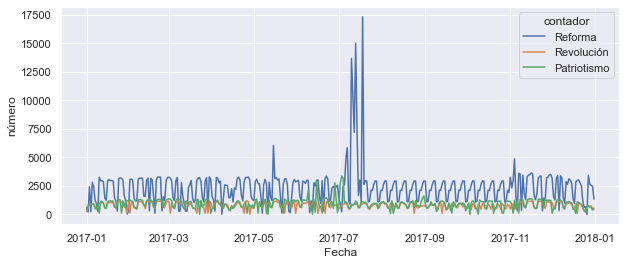

In [37]:
data_lineplot2 = pd.melt(contador.loc[contador['Año'] == 2017,['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot2)

#Change figure size
sns.set(rc={'figure.figsize':(10,4)});

Yes, we seem to have data for all months, so let's proceed to deal with the missing values.

### Missing values

Now we have to deal with the **missing values**. The values for Revolución and Patriotismo up to 14 June 2016 are simple: we could replace them with a cero, since cero bicycles were, in a way, counted by the counters.

In [21]:
# Fill missing values up to the installation of the counters.
contador.loc[0:940, ['Revolución', 'Patriotismo']] = contador.loc[0:940, ['Revolución', 'Patriotismo']].fillna(0)

For the other ones, let's look at them more closely:

In [22]:
contador[contador['Reforma'].isnull()].head()

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
1341,miercoles,19,julio,2017,2017-07-19,NaN,1017.0,1061.0
1342,jueves,20,julio,2017,2017-07-20,NaN,959.0,1081.0
1343,viernes,21,julio,2017,2017-07-21,NaN,878.0,963.0
1344,sabado,22,julio,2017,2017-07-22,NaN,627.0,558.0
1345,domingo,23,julio,2017,2017-07-23,NaN,423.0,580.0


In [23]:
contador.iloc[1336:1346, :]

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
1336,viernes,14,julio,2017,2017-07-14,7291.0,1007.0,1041.0
1337,sabado,15,julio,2017,2017-07-15,1674.0,629.0,571.0
1338,domingo,16,julio,2017,2017-07-16,3013.0,600.0,679.0
1339,lunes,17,julio,2017,2017-07-17,1061.0,926.0,1077.0
1340,martes,18,julio,2017,2017-07-18,17327.0,914.0,1111.0
1341,miercoles,19,julio,2017,2017-07-19,NaN,1017.0,1061.0
1342,jueves,20,julio,2017,2017-07-20,NaN,959.0,1081.0
1343,viernes,21,julio,2017,2017-07-21,NaN,878.0,963.0
1344,sabado,22,julio,2017,2017-07-22,NaN,627.0,558.0
1345,domingo,23,julio,2017,2017-07-23,NaN,423.0,580.0


It is unlikely that cyclists simply stoped passing through Reforma, since they were passing through the other counters. Also, the period is too long for it to overlap with, say, a holiday. My hypothesis is that the counter simply stoped working for some reason.

The same is probably happening for the final values of the Reforma counter:

In [24]:
contador[contador['Reforma'].notnull()].tail()

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
2292,sabado,11,julio,2020,2020-07-11,1913.0,710.0,674.0
2293,domingo,12,julio,2020,2020-07-12,2550.0,605.0,814.0
2294,lunes,13,julio,2020,2020-07-13,1835.0,711.0,565.0
2295,martes,14,julio,2020,2020-07-14,1782.0,774.0,627.0
2296,miercoles,15,julio,2020,2020-07-15,2008.0,738.0,643.0


In [25]:
contador.iloc[2293:2304, :]

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
2293,domingo,12,julio,2020,2020-07-12,2550.0,605.0,814.0
2294,lunes,13,julio,2020,2020-07-13,1835.0,711.0,565.0
2295,martes,14,julio,2020,2020-07-14,1782.0,774.0,627.0
2296,miercoles,15,julio,2020,2020-07-15,2008.0,738.0,643.0
2297,jueves,16,julio,2020,2020-07-16,NaN,749.0,693.0
2298,viernes,17,julio,2020,2020-07-17,NaN,858.0,697.0
2299,sabado,18,julio,2020,2020-07-18,NaN,706.0,686.0
2300,domingo,19,julio,2020,2020-07-19,NaN,634.0,878.0
2301,lunes,20,julio,2020,2020-07-20,NaN,750.0,581.0
2302,martes,21,julio,2020,2020-07-21,NaN,802.0,676.0


Indeed, the counter stops abruptly, while the other counters keep going without any problem. 

To handle these missing value, I will use the **mean of the past month's corresponding day**. So, for example, if a value is missing on Sunday of July 2020 , I will replace it with the average of all Sundays from June 2020. I believe this gives us the best approximation. 

I discarded other alternatives because:
- Using the _global average or the mode_ would be misleading, since the number of cyclists over time will probably fluctuate.
- _Dropping_ the missing values would alter the total cyclists in a given year since the nulls are clustered in certain areas.
- Using a _forward fill_ (that is, populating with the last valid observation) would be innaccurate, since each day will probably have different number of cyclists (see graph below). Also, in the previous linechart, we saw a spike in the counter just before the missing values, so it would populate with this outlier values. 

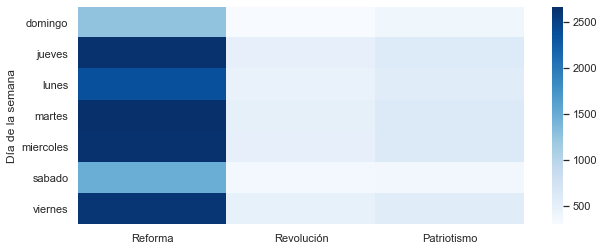

In [26]:
sns.heatmap(contador.groupby('Día de la semana')[['Reforma', 'Revolución', 'Patriotismo']].mean(), cmap='Blues');

Indeed, weekends tend to be much less crowded.
Therefore, let's use the mean of the past month's corresponding day.

In [27]:
# Calculate mean of each day of each month and year. 
means = pd.DataFrame(contador.groupby([ 'Año', 'Mes', 'Día de la semana'])['Reforma' ,'Revolución', 'Patriotismo'].mean()).sort_index().reset_index()
means

<ipython-input-27-7d520ddacd05>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = pd.DataFrame(contador.groupby([ 'Año', 'Mes', 'Día de la semana'])['Reforma' ,'Revolución', 'Patriotismo'].mean()).sort_index().reset_index()


,Año,Mes,Día de la semana,Reforma,Revolución,Patriotismo
0,2013,diciembre,domingo,1004.00,0.00,0.00
1,2013,diciembre,jueves,2044.00,0.00,0.00
2,2013,diciembre,lunes,1916.40,0.00,0.00
3,2013,diciembre,martes,1530.20,0.00,0.00
4,2013,diciembre,miercoles,1984.25,0.00,0.00
...,...,...,...,...,...,...
548,2020,septiembre,lunes,NaN,628.75,565.00
549,2020,septiembre,martes,NaN,698.00,659.60
550,2020,septiembre,miercoles,NaN,657.20,678.80
551,2020,septiembre,sabado,NaN,615.25,637.75


In [28]:
contador.head(3)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
0,sabado,16,noviembre,2013,2013-11-16,613.0,0.0,0.0
1,domingo,17,noviembre,2013,2013-11-17,1084.0,0.0,0.0
2,lunes,18,noviembre,2013,2013-11-18,1073.0,0.0,0.0


In [29]:
# Define list of months and counters
months = ['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre',
 'diciembre']
counters = ['Reforma', 'Revolución', 'Patriotismo']

The following block of code substitutes the missing values. However, we should be wary of using any means in the month of July 2017, since we got outlier values in that month. For those cases, we could use the values for June 2017.

In [30]:
# Fill missing values with the mean of the past month's corresponding day.
for counter in counters:
    for i in contador.index.tolist():
        if pd.isnull(contador.loc[i, counter]):
            # Get current date
            day = contador['Día de la semana'][i]
            month = contador['Mes'][i]
            year = contador['Año'][i]

            # Get mean of last available month.
            mean_last_available_month = np.NaN
            index_adjuster = 0
            while pd.isnull(mean_last_available_month):
                # Get past month and its year
                index_adjuster -= 1
                last_available_month = months[months.index(month)+index_adjuster]
                year_last_available_month = year

                if last_available_month == 'diciembre':
                    year_last_available_month -= 1

                ### Avoid outlier values from July 2017
                if last_available_month == 'julio':
                    index_adjuster -= 1
                    last_available_month = months[months.index(month)+index_adjuster]

                # Get mean of past month
                mean_last_available_month = means.loc[(means.Año == year_last_available_month) & (means.Mes == last_available_month) & (means['Día de la semana'] == day), counter].iloc[0]         

            # Assign value to cell 
            contador.loc[i, counter] = mean_last_available_month

            # Print value assigned to cell
            print(f'- Value: {mean_last_available_month} | {counter} | {i} | Year: {year_last_available_month} | Av. Month: {last_available_month} | Month: {month} | Day: {day}')

- Value: 2644.0 | Reforma | 1341 | Year: 2017 | Av. Month: junio | Month: julio | Day: miercoles
- Value: 2947.0 | Reforma | 1342 | Year: 2017 | Av. Month: junio | Month: julio | Day: jueves
- Value: 2929.6 | Reforma | 1343 | Year: 2017 | Av. Month: junio | Month: julio | Day: viernes
- Value: 1099.25 | Reforma | 1344 | Year: 2017 | Av. Month: junio | Month: julio | Day: sabado
- Value: 1157.5 | Reforma | 1345 | Year: 2017 | Av. Month: junio | Month: julio | Day: domingo
- Value: 2129.75 | Reforma | 1346 | Year: 2017 | Av. Month: junio | Month: julio | Day: lunes
- Value: 2104.5 | Reforma | 1347 | Year: 2017 | Av. Month: junio | Month: julio | Day: martes
- Value: 2644.0 | Reforma | 1348 | Year: 2017 | Av. Month: junio | Month: julio | Day: miercoles
- Value: 2947.0 | Reforma | 1349 | Year: 2017 | Av. Month: junio | Month: julio | Day: jueves
- Value: 2929.6 | Reforma | 1350 | Year: 2017 | Av. Month: junio | Month: julio | Day: viernes
- Value: 1099.25 | Reforma | 1351 | Year: 2017 | A

- Value: 2819.5 | Reforma | 1726 | Year: 2018 | Av. Month: junio | Month: agosto | Day: miercoles
- Value: 2586.5 | Reforma | 1727 | Year: 2018 | Av. Month: junio | Month: agosto | Day: jueves
- Value: 2748.4 | Reforma | 1728 | Year: 2018 | Av. Month: junio | Month: agosto | Day: viernes
- Value: 1375.4 | Reforma | 1729 | Year: 2018 | Av. Month: junio | Month: agosto | Day: sabado
- Value: 1535.5 | Reforma | 1730 | Year: 2018 | Av. Month: junio | Month: agosto | Day: domingo
- Value: 2029.75 | Reforma | 1731 | Year: 2018 | Av. Month: junio | Month: agosto | Day: lunes
- Value: 1735.0 | Reforma | 2297 | Year: 2020 | Av. Month: junio | Month: julio | Day: jueves
- Value: 1804.0 | Reforma | 2298 | Year: 2020 | Av. Month: junio | Month: julio | Day: viernes
- Value: 1801.75 | Reforma | 2299 | Year: 2020 | Av. Month: junio | Month: julio | Day: sabado
- Value: 2312.75 | Reforma | 2300 | Year: 2020 | Av. Month: junio | Month: julio | Day: domingo
- Value: 1396.2 | Reforma | 2301 | Year: 2020

- Value: 530.3333333333334 | Revolución | 1429 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: domingo
- Value: 908.0 | Revolución | 1430 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: lunes
- Value: 785.6666666666666 | Revolución | 1431 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: martes
- Value: 455.0 | Revolución | 1432 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: miercoles
- Value: 950.0 | Revolución | 1433 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: jueves
- Value: 844.6666666666666 | Revolución | 1434 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: viernes
- Value: 479.0 | Revolución | 1435 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: sabado
- Value: 530.3333333333334 | Revolución | 1436 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: domingo
- Value: 908.0 | Revolución | 1437 | Year: 2017 | Av. Month: septiembre | Month: octubre | Day: lunes
- Value: 785.66666666

By doing a quick scan of the values we used for replacement, there don't appear to be any outliers.

In [31]:
contador.isnull().sum()

Día de la semana    0
Día                 0
Mes                 0
Año                 0
Fecha               0
Reforma             0
Revolución          0
Patriotismo         0
dtype: int64

Also, we do not have any missing values. Let's see how our new dataset looks like:

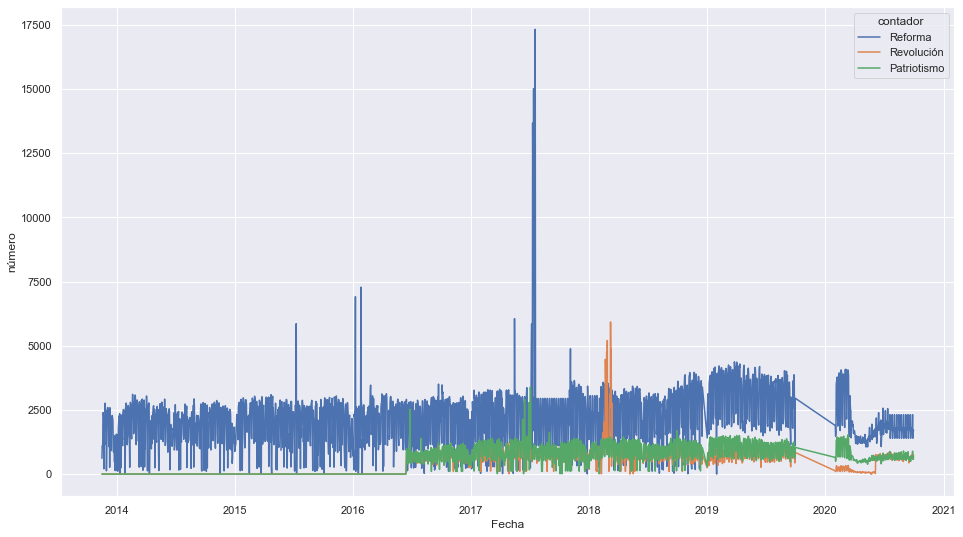

In [39]:
sns.set_theme()
data_lineplot = pd.melt(contador[['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot)

#Change figure size
sns.set(rc={'figure.figsize':(16,9)});

### Save dataset

In [33]:
# Create column with total cyclists of a given day
contador['total'] = contador['Patriotismo'] + contador['Revolución'] + contador['Reforma']
contador['total'] = contador['total'].astype('int64')

In [40]:
# Change column type to integer.
for counter in counters:
    contador[counter] = contador[counter].astype('int64')

In [41]:
contador.head()

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo,total
0,sabado,16,noviembre,2013,2013-11-16,613,0,0,613
1,domingo,17,noviembre,2013,2013-11-17,1084,0,0,1084
2,lunes,18,noviembre,2013,2013-11-18,1073,0,0,1073
3,martes,19,noviembre,2013,2013-11-19,1344,0,0,1344
4,miercoles,20,noviembre,2013,2013-11-20,2394,0,0,2394


In [42]:
contador_final = contador.copy()

In [43]:
contador_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2374 entries, 0 to 2373
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Día de la semana  2374 non-null   object        
 1   Día               2374 non-null   int64         
 2   Mes               2374 non-null   object        
 3   Año               2374 non-null   int64         
 4   Fecha             2374 non-null   datetime64[ns]
 5   Reforma           2374 non-null   int64         
 6   Revolución        2374 non-null   int64         
 7   Patriotismo       2374 non-null   int64         
 8   total             2374 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 167.0+ KB


In [44]:
contador_final.to_csv('Data/contador_final.csv', index=False)

# 2. Road accidents

### Data exploration

In [45]:
incidentes.head(4)

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,C5/191016/01871,16/10/2019,09:04:53,Miércoles,(A) La unidad de atención a emergencias fue de...,16/10/2019,2019,Octubre,09:23:53,VENUSTIANO CARRANZA,accidente-ciclista,19.44961,-99.11384,URGENCIAS MEDICAS,LLAMADA DEL 911,VENUSTIANO CARRANZA,"19.44961002,-99.11383992",10
1,C5/191016/03921,16/10/2019,13:35:39,Miércoles,(N) La unidad de atención a emergencias fue de...,16/10/2019,2019,Octubre,13:45:34,IZTAPALAPA,accidente-ciclista,19.36409,-99.06687,URGENCIAS MEDICAS,LLAMADA DEL 911,IZTAPALAPA,"19.36409004,-99.06687",10
2,C5/191016/05840,16/10/2019,17:35:24,Miércoles,(D) El incidente reportado se registró en dos ...,16/10/2019,2019,Octubre,17:43:03,CUAUHTEMOC,accidente-ciclista,19.42287,-99.12929,URGENCIAS MEDICAS,LLAMADA DEL 911,CUAUHTEMOC,"19.42287003,-99.12929004",10
3,C5/191017/02907,17/10/2019,11:27:11,Jueves,(A) La unidad de atención a emergencias fue de...,17/10/2019,2019,Octubre,12:16:53,CUAUHTEMOC,accidente-ciclista,19.43451,-99.14268,URGENCIAS MEDICAS,LLAMADA DEL 911,CUAUHTEMOC,"19.43451,-99.14267988",10


Let's work only with the columns that seem relevant for our purposes. 

In [46]:
incidentes = incidentes[['dia_semana', 'fecha_creacion', 'hora_creacion', 'mes', 'delegacion_inicio', 'latitud', 'longitud', 'geopoint']]

In [47]:
incidentes.head(4)

,dia_semana,fecha_creacion,hora_creacion,mes,delegacion_inicio,latitud,longitud,geopoint
0,Miércoles,16/10/2019,09:04:53,10,VENUSTIANO CARRANZA,19.44961,-99.11384,"19.44961002,-99.11383992"
1,Miércoles,16/10/2019,13:35:39,10,IZTAPALAPA,19.36409,-99.06687,"19.36409004,-99.06687"
2,Miércoles,16/10/2019,17:35:24,10,CUAUHTEMOC,19.42287,-99.12929,"19.42287003,-99.12929004"
3,Jueves,17/10/2019,11:27:11,10,CUAUHTEMOC,19.43451,-99.14268,"19.43451,-99.14267988"


In [48]:
incidentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dia_semana         2924 non-null   object 
 1   fecha_creacion     2924 non-null   object 
 2   hora_creacion      2924 non-null   object 
 3   mes                2924 non-null   int64  
 4   delegacion_inicio  2924 non-null   object 
 5   latitud            2924 non-null   float64
 6   longitud           2924 non-null   float64
 7   geopoint           2924 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 182.9+ KB


We should transform the date and hour columns to a single datetime column. Also, let's see the distribution of hours of the reports, to check whether there are any mistakes.

In [49]:
incidentes.hora_creacion.value_counts()

18:50:41    2
19:19:09    2
13:49:30    2
13:50:13    2
20:51:00    2
           ..
17:28:53    1
15:45:56    1
00:34:00    1
13:31:32    1
05:49:58    1
Name: hora_creacion, Length: 2849, dtype: int64

All the hours seem to be properly registered. Now let's check the format:

In [50]:
incidentes.loc[incidentes['hora_creacion'].str.match(r'\d\d:\d\d:\d\d') == False, 'hora_creacion']

1166    0.796273148
1167     0.48255787
1168    0.793344907
1169    0.617974537
1170    0.756168981
1171    0.616134259
1172    0.519444444
1357    0.706597222
1358     0.37505787
1359    0.683344907
1360    0.626226852
1361    0.812592593
1609    0.373958333
1610    0.377256944
2109    0.861365741
2164    0.474282407
2165    0.799143519
2661    0.996238426
2749       0.998125
Name: hora_creacion, dtype: object

We have multiple values that do not have the proper format. Let's see if they represent time expressed as number of seconds, in decimal form. 

In [51]:
t = "11:12:21"
(h, m, s) = t.split(':')
result = int(h) * 3600 + int(m) * 60 + int(s)
result

40341

No, the numbers we had before are too large to represent seconds. Also, they do not seem to have a distinguishable pattern. Therefore, let's just drop them. 

In [52]:
len(incidentes)

2924

In [53]:
incidentes = incidentes[incidentes['hora_creacion'].str.match(r'\d\d:\d\d:\d\d') == True]

In [54]:
len(incidentes)

2905

Now let's proceed to transform the time columns.

### Data cleaning

In [55]:
# Clean day column.
incidentes['dia_semana'] = incidentes['dia_semana'].str.lower()

In [56]:
# Combine date and time columns
fecha_hora = pd.Series(incidentes['fecha_creacion'] + ' ' + incidentes['hora_creacion'])

In [57]:
# Insert new column
incidentes.insert(1, 'fecha_hora', fecha_hora)

In [58]:
# Change new column to datetime format
incidentes['fecha_hora'] = pd.to_datetime(incidentes['fecha_hora'], format='%d/%m/%Y %H:%M:%S')

In [59]:
# Change type of time columns
incidentes['fecha_creacion'] = pd.to_datetime(incidentes['fecha_creacion'], format='%d/%m/%Y')
incidentes['hora_creacion'] = pd.to_datetime(incidentes['hora_creacion'], format='%H:%M:%S').dt.time

In [60]:
incidentes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2905 entries, 0 to 2923
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dia_semana         2905 non-null   object        
 1   fecha_hora         2905 non-null   datetime64[ns]
 2   fecha_creacion     2905 non-null   datetime64[ns]
 3   hora_creacion      2905 non-null   object        
 4   mes                2905 non-null   int64         
 5   delegacion_inicio  2905 non-null   object        
 6   latitud            2905 non-null   float64       
 7   longitud           2905 non-null   float64       
 8   geopoint           2905 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 227.0+ KB


In [61]:
# Drop extra columns
incidentes.drop(['fecha_creacion', 'mes'], axis=1, inplace=True)

# Create new columns with year, month, and hour. 
incidentes.insert(2, 'hora', incidentes['fecha_hora'].dt.hour)
incidentes.insert(2, 'mes', incidentes['fecha_hora'].dt.month)
incidentes.insert(2, 'año', incidentes['fecha_hora'].dt.year)

In [62]:
incidentes.head(4)

,dia_semana,fecha_hora,año,mes,hora,hora_creacion,delegacion_inicio,latitud,longitud,geopoint
0,miércoles,2019-10-16 09:04:53,2019,10,9,09:04:53,VENUSTIANO CARRANZA,19.44961,-99.11384,"19.44961002,-99.11383992"
1,miércoles,2019-10-16 13:35:39,2019,10,13,13:35:39,IZTAPALAPA,19.36409,-99.06687,"19.36409004,-99.06687"
2,miércoles,2019-10-16 17:35:24,2019,10,17,17:35:24,CUAUHTEMOC,19.42287,-99.12929,"19.42287003,-99.12929004"
3,jueves,2019-10-17 11:27:11,2019,10,11,11:27:11,CUAUHTEMOC,19.43451,-99.14268,"19.43451,-99.14267988"


In [63]:
# Remove special characters
incidentes['dia_semana'] = incidentes['dia_semana'].str.replace('á', 'a').str.replace('é', 'e')

In [64]:
incidentes.head()

,dia_semana,fecha_hora,año,mes,hora,hora_creacion,delegacion_inicio,latitud,longitud,geopoint
0,miercoles,2019-10-16 09:04:53,2019,10,9,09:04:53,VENUSTIANO CARRANZA,19.44961,-99.11384,"19.44961002,-99.11383992"
1,miercoles,2019-10-16 13:35:39,2019,10,13,13:35:39,IZTAPALAPA,19.36409,-99.06687,"19.36409004,-99.06687"
2,miercoles,2019-10-16 17:35:24,2019,10,17,17:35:24,CUAUHTEMOC,19.42287,-99.12929,"19.42287003,-99.12929004"
3,jueves,2019-10-17 11:27:11,2019,10,11,11:27:11,CUAUHTEMOC,19.43451,-99.14268,"19.43451,-99.14267988"
4,viernes,2019-10-18 18:11:00,2019,10,18,18:11:00,BENITO JUAREZ,19.38966,-99.18504,"19.38966003,-99.18504"


In [65]:
# Transform months back to text
incidentes['mes'] = incidentes['mes'].map(dict_meses_inverso)

### Save dataset

In [66]:
incidentes_final = incidentes.copy()

In [67]:
incidentes_final.to_csv('Data/incidentes_final.csv', index=False)

## 3. Estudio 2018 Ciclismo

### Data exploration

In [68]:
estudio.head(4)

,PUNTO_LEV,ID_UNICO,FOLIO,CALLE_LEV,CALLE_1,CALLE_2,RESUL,F1,P1,MUNORI,...,P26_1,P26_2,P26_3,P26_4,P26_5,P26_6,P26_7,P26_8,P27,FACTOR
0,11,103,6,CAMINO VIEJO A MIXCOAC,3RA CERRADA TORRES TEPITO,2DA CERRADA TORRES TEPITO,1,48,2,9010,...,2,2,1,2,2,2,2,1,4,30.26
1,9,75,2,VASCO DE QUIROGA,POLVORA,NaN,1,35,1,9010,...,2,2,1,2,2,2,2,2,4,26.72
2,9,79,5,VASCO DE QUIROGA,POLVORA,NaN,1,43,2,9010,...,2,2,2,2,2,2,1,2,4,26.72
3,8,70,5,POSTA,STA LUCIA,NaN,1,54,1,9010,...,2,2,2,2,2,2,2,2,3,73.07


We have too many columns, so let's expand the default display configuration to analyze them. 

In [69]:
pd.set_option('display.max_columns', 500)
estudio.head(4)

,PUNTO_LEV,ID_UNICO,FOLIO,CALLE_LEV,CALLE_1,CALLE_2,RESUL,F1,P1,MUNORI,P2_COL,P2_REF1,P2_REF2,P3,MUNDES,P4_COL,P4_REF1,P4_REF2,P5,P6,P7_HR,P7_MIN,P8_HR,P8_MIN,P9,P9_1,P10,P11,P11_1,P12,P13,P14_1,P14_2,P14_3,P14_4,P15,P16_1,P16_2,P16_3,P16_4,P16_5,P16_6,P16_7,P16_8,P17,P17_1,P17_2,P17_3,P18,P19,P20,P21_NIVEL,NIVEL,P21_AÑO,P22,P23,P23_1,P24,P24_1,P25,P26_1,P26_2,P26_3,P26_4,P26_5,P26_6,P26_7,P26_8,P27,FACTOR
0,11,103,6,CAMINO VIEJO A MIXCOAC,3RA CERRADA TORRES TEPITO,2DA CERRADA TORRES TEPITO,1,48,2,9010,SAN BARTOLO,NaN,NaN,1,9010,SAN BARTOLO,NaN,NaN,5,2,17,30,17,55,2,0.0,NaN,2,0.0,NaN,2.0,2,1,1,2,3,2,1,2,2,1,1,2,2,1,2.0,3.0,2.0,1,1.0,1,4,3,3,60,5000,3,1,2,4,2,2,1,2,2,2,2,1,4,30.26
1,9,75,2,VASCO DE QUIROGA,POLVORA,NaN,1,35,1,9010,LA MEXICANA,NaN,NaN,3,9010,NO RECUERDA,NaN,NaN,2,9,10,40,11,5,2,0.0,NaN,2,0.0,NaN,1.0,3,4,4,4,10,1,2,2,2,1,2,1,2,1,1.0,3.0,2.0,2,NaN,1,9,5,1,200,30000,6,1,2,4,2,2,1,2,2,2,2,2,4,26.72
2,9,79,5,VASCO DE QUIROGA,POLVORA,NaN,1,43,2,9010,MEXICANA,NaN,NaN,2,9010,SANTA FE,NaN,NaN,4,1,11,45,11,55,2,0.0,NaN,2,0.0,NaN,1.0,4,4,4,4,10,2,2,2,2,1,2,2,2,1,2.0,9.0,1.0,2,NaN,1,3,1,4,170,8000,4,1,2,2,2,2,2,2,2,2,1,2,4,26.72
3,8,70,5,POSTA,STA LUCIA,NaN,1,54,1,9010,AMPLIACION PILOTO,NaN,NaN,7,9010,COLINA DEL SUR,NaN,NaN,4,9,14,2,14,20,1,1.0,4.0,2,0.0,NaN,1.0,4,4,4,4,3,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,2,NaN,1,4,3,3,800,999999,4,1,2,1,2,2,2,2,2,2,2,2,3,73.07


This dataset is based on a large questionaire and, unfortunately, it is label encoded and abreviated. Therefore, one has to read the [accompanying file](https://github.com/FranciscoGalan/Bicycle_Commuting_Mexico_City/blob/main/Data/Diccionario%20Estudio%20de%20Conteo%20Ciclista%202018.csv) of the dataset, which explains what each label means. 

I already did a preselection of the columns that interest me, so I'll proceed to select them. 

In [70]:
columnas = ['CALLE_LEV', 'F1', 'P1', 'P3', 'P6', 'P15', 'P18', 'P19', 'P20', 'P21_NIVEL', 'P23_1']
estudio1 = estudio.copy()
estudio1 = estudio1[columnas]

Now, let's change the names of the columns so they are easier to understand.

In [71]:
# Create dictionary to rename columns
nombres = ['calle_lev', 'edad', 'origen', 'destino', 'motivo_viaje', 'motivo_dejar_bici', 'robado_bici', 'robo_forma', 'sexo', 'educacion', 'ingreso_mensual']
ch_columnas = estudio1.columns.tolist()
res = {ch_columnas[i]: nombres[i] for i in range(len(ch_columnas))}

In [72]:
# Rename columns
estudio1 = estudio1.rename(columns=res)

We should also remove the label encoding and insert, instead, the textual information.

In [73]:
# Create dictionaries with number-text answer
dict_origen = {1:'Hogar',
              2:'Trabajo',
              3:'Escuela',
              4:'Centro comercial, tienda, mercado',
              5:'Otra vivienda',
              6:'Restaurante, bar, cafetería',
              7:'Otro',
              98:'No sabe',
              99:'No sabe'}
dict_destino = {1:'Hogar',
              2:'Trabajo',
              3:'Escuela',
              4:'Centro comercial, tienda, mercado',
              5:'Otra vivienda',
              6:'Restaurante, bar, cafetería',
              7:'Otro',
              98:'No sabe',
              99:'No sabe'}
dict_motivo_viaje = {1:'Ir al trabajo',
                    2:'Regreso a casa',
                    3:'Ir a estudiar',
                    4:'Hacer compras',
                    5:'Llevar o recoger a alguien',
                    6:'Recreación',
                    7:'Ir a comer',
                    8:'Relacionado con el trabajo',
                    9:'Trámite',
                    10:'Ir de visita',
                    98:'No sabe',
                    99:'No contestó'}
dict_motivo_dejar_bici = {1:'Lesión o incapacidad',
                         2:'Fala mecánica de bici',
                         3: 'Cambio de trabajo',
                         4: 'Llevar prisa',
                         5: 'Recorrido muy largo',
                         6: 'Falta de infraestructura',
                         7: 'Clima',
                         8: 'Inseguridad',
                         9: 'No haya bici disponible',
                         10: 'Ningún motivo',
                         11: 'No sé',
                         12: 'No contestó'}
dict_robado_bici = {1:'Sí', 2:'No', 8:'No sabe', 9:'No contestó'}
dict_robo_forma = {1:'Estacionada', 2:'En movimiento', 8:'No sabe', 9:'No contestó'}
dict_sexo = {1: 'Hombre', 2:'Mujer'}
dict_educacion = {1:'Ninguno',
                 2:'Preescolar',
                 3:'Primaria',
                 4:'Secundaria',
                 5:'Preparatoria o Bachillerato',
                 6:'Normal',
                 7:'Carrera Técnica',
                 8:'Licenciatura',
                 9:'Maestría',
                 10:'Doctorado',
                 98:'No sabe',
                  99:'No contestó'}
dict_ingreso_mensual = {1:'>1,000',
                       2:'1,001-3,000',
                       3:'3,001-6,000',
                       4:'6,001-10,000',
                       5:'10,001-15000',
                       6:'<15,001',
                       9:'No contestó'}

In [74]:
# Change values in columns
columns = estudio1.columns[2:].to_list()
dictionaries = [dict_origen, dict_destino, dict_motivo_viaje, dict_motivo_dejar_bici, dict_robado_bici,
              dict_robo_forma, dict_sexo, dict_educacion, dict_ingreso_mensual]

for i in range(len(columns)):
    estudio1[columns[i]] = estudio1[columns[i]].map(dictionaries[i])

In [75]:
estudio1.head() 

,calle_lev,edad,origen,destino,motivo_viaje,motivo_dejar_bici,robado_bici,robo_forma,sexo,educacion,ingreso_mensual
0,CAMINO VIEJO A MIXCOAC,48,Trabajo,Hogar,Regreso a casa,Cambio de trabajo,Sí,Estacionada,Hombre,Secundaria,"3,001-6,000"
1,VASCO DE QUIROGA,35,Hogar,Escuela,Trámite,Ningún motivo,No,NaN,Hombre,Maestría,"<15,001"
2,VASCO DE QUIROGA,43,Trabajo,Trabajo,Ir al trabajo,Ningún motivo,No,NaN,Hombre,Primaria,"6,001-10,000"
3,POSTA,54,Hogar,Otro,Trámite,Cambio de trabajo,No,NaN,Hombre,Secundaria,"6,001-10,000"
4,CALZADA DE LOS LEONES,35,Hogar,"Centro comercial, tienda, mercado",Hacer compras,Ningún motivo,No,NaN,Hombre,Licenciatura,"10,001-15000"


### Save dataset

In [76]:
estudio_final = estudio1.copy()

In [77]:
estudio_final.to_csv('Data/estudio_final.csv', index=False)

#### Save dataset of motivo_dejar bici

In [78]:
a = pd.Series(estudio_final['motivo_dejar_bici'].value_counts())

In [79]:
a.to_csv('Data/motivo_dejar_final.csv')